# Circular heat plate

In [1]:
import CairoMakie
import Plots: spy

using MMJMesh.Meshes
using MMJMesh.Plots
using MMJMesh.Gmsh
using LinearAlgebra

using Revise

include("fem.jl")
include("heat.jl")
CairoMakie.update_theme!(colormap=:acton)

## Parameters

In [2]:
p = (
    r = 2.2,
    λ = 1.05,
    w = 7.9
)

(r = 2.2, λ = 1.05, w = 7.9)

## Mesh

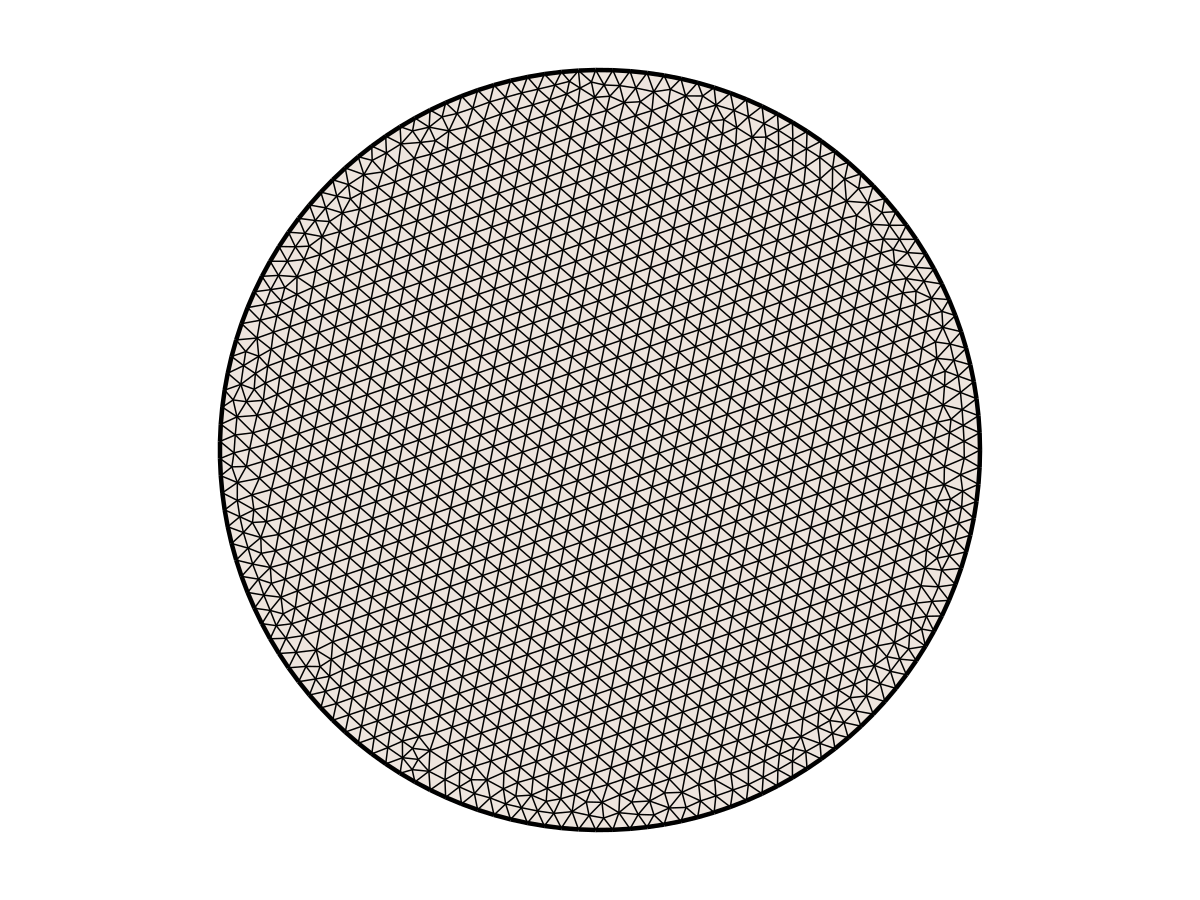

In [3]:
m = Mesh("gmsh/disk.msh")
mplot(m, edgesvisible=true) |> mconf()

## Solution

### Define problem

In [4]:
m.data[:kefunc] = heatKe(p.λ)
m.data[:refunc] = heatRe(p.w)

(::var"#reFunc#10"{Float64}) (generic function with 1 method)

### Set up linear system

In [5]:
dofs = m.groups[:boundarynodes]
K, r = assembleKr(m)

applyDirichletBCs!(dofs,K,r)
# display(K)
# display(r)

139-element view(::Vector{Float64}, [1, 1879, 3757, 5635, 7513, 9391, 11269, 13147, 15025, 16903  …  242263, 244141, 246019, 247897, 249775, 251653, 253531, 255409, 257287, 259165]) with eltype Float64:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

### Solution

Linear system

In [6]:
# u hut berechnen = Verschiebungsvektor
θhat = K \ r



1877-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.1397886954645684
 0.4733685134366146
 1.2791697775113267
 1.196895685458949
 1.103908786336632
 0.4384205048810895
 1.1513744800913437
 1.2077632337509916
 1.2126790853987581

In [7]:
using SparseArrays

# sparse = dünnbesetzte Matrix = Matrix mit vielen Nullen 
# sparse() speichert die Nullen der Matrix nicht, daher ist es schneller zu berechnen

KSparse = sparse(K)
@time That = K \ r;
@time That = KSparse \ r;

  0.063011 seconds (4 allocations: 26.908 MiB)
  1.451851 seconds (2.22 M allocations: 153.547 MiB, 3.92% gc time, 97.18% compilation time)


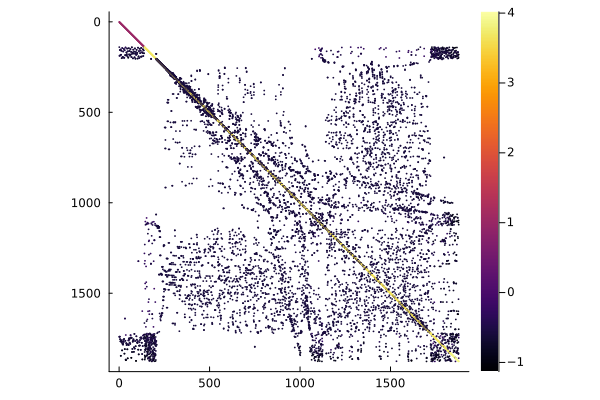

In [8]:
import Plots:spy
spy(K)

Comparison to exact solution

In [9]:
println(maximum(θhat))
println((p.w/(4*p.λ)) * ((p.r^2)))

9.099218457337066
9.103809523809526


In [10]:
function theta(x1,x2)
    theta= (p.w/(4*p.λ)) * ((p.r^2)-(x1^2)-(x2^2))
    return theta
end

nn = nnodes(m)
θ = zeros(nn)

for k in 1:nn
    x1 = coordinates(node(m,k))[1]
    x2 = coordinates(node(m,k))[2]
    
    θ[k] = theta(x1,x2)
end
θ


1877-element Vector{Float64}:
  0.0
 -1.0310865917686908e-15
  2.1535352866054932e-15
  5.612243474184013e-15
  5.742760764281315e-16
 -4.594208611425052e-15
  5.0118639397364205e-15
  2.7147596340238947e-15
  2.7147596340238947e-15
  2.9235872981795788e-15
  ⋮
  1.1415718081028545
  0.4752677549352703
  1.2811107155044743
  1.1985529736930003
  1.105704258951311
  0.4401466780060058
  1.1527692149921729
  1.2094774918624742
  1.2129685656519777

Plot

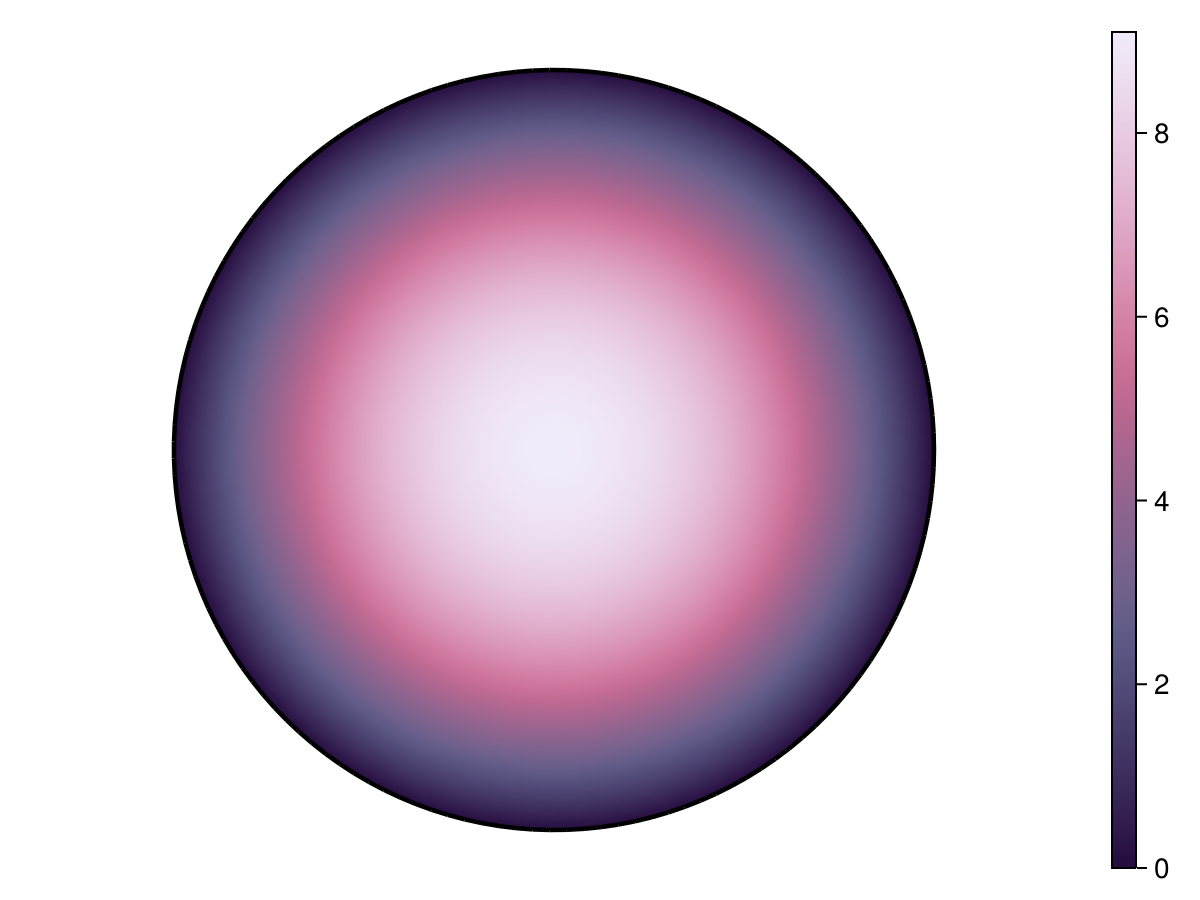

In [11]:
mplot(m,θhat)|>mconf()

Error

In [12]:
error = abs.(θhat - θ)

1877-element Vector{Float64}:
 0.0
 1.0310865917686908e-15
 2.1535352866054932e-15
 5.612243474184013e-15
 5.742760764281315e-16
 4.594208611425052e-15
 5.0118639397364205e-15
 2.7147596340238947e-15
 2.7147596340238947e-15
 2.9235872981795788e-15
 ⋮
 0.0017831126382861218
 0.0018992414986556683
 0.0019409379931476511
 0.0016572882340513129
 0.001795472614679161
 0.001726173124916297
 0.0013947349008291976
 0.001714258111482625
 0.00028948025321962056